<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
from catboost import Pool, CatBoostRegressor, cv
import catboost as cb

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 

from sklearn.metrics import make_scorer, mean_squared_error 

## Подготовка

In [2]:
df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0]) 

In [3]:
display(df.index.is_monotonic)
display(df.head(10))
df.info()

True

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<div class="alert alert-block alert-info">
Данные в хронологическом порядке, что отлично
</div>


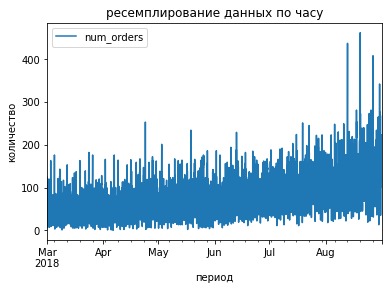

In [4]:
df = df.resample('1H').sum() 
df.plot();
plt.title("ресемплирование данных по часу");
plt.xlabel("период");
plt.ylabel("количество");

<div class="alert alert-block alert-info">  
Данные состоят из 2 столбцов datetime - дата и время и целевой признак num_orders - количество заказов. Пропуски отсутствуют, данные имеют большую частоту
</div>


## Анализ

print('Starting date:',df.index.min())
print('Ending date:',df.index.max())
print('Total time:',df.index.max() - df.index.min())
print()
df.describe()

<div class="alert alert-block alert-info">  
Проверили разброс данных, всего у нас информации за 183 дня, с 01.03.2018 по 31.08.2018, количество заказов от 0 до 462
</div>


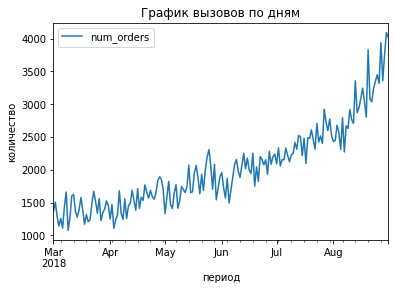

In [5]:
df.resample('1D').sum().plot();
plt.title("График вызовов по дням");
plt.xlabel("период");
plt.ylabel("количество");

<div class="alert alert-block alert-info">  
График вызовов по дням
</div>


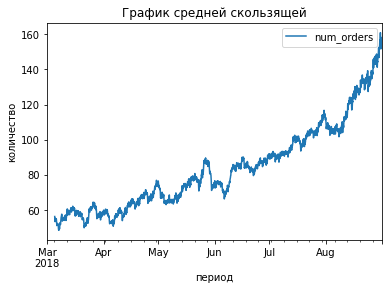

In [6]:
df.rolling(100).mean().plot();
plt.title("График средней скользящей");
plt.xlabel("период");
plt.ylabel("количество");

<div class="alert alert-block alert-info">  
Данные имеют большие колебания, но с помощью средней скользящей мы уже видим восхдящий тренд.
</div>


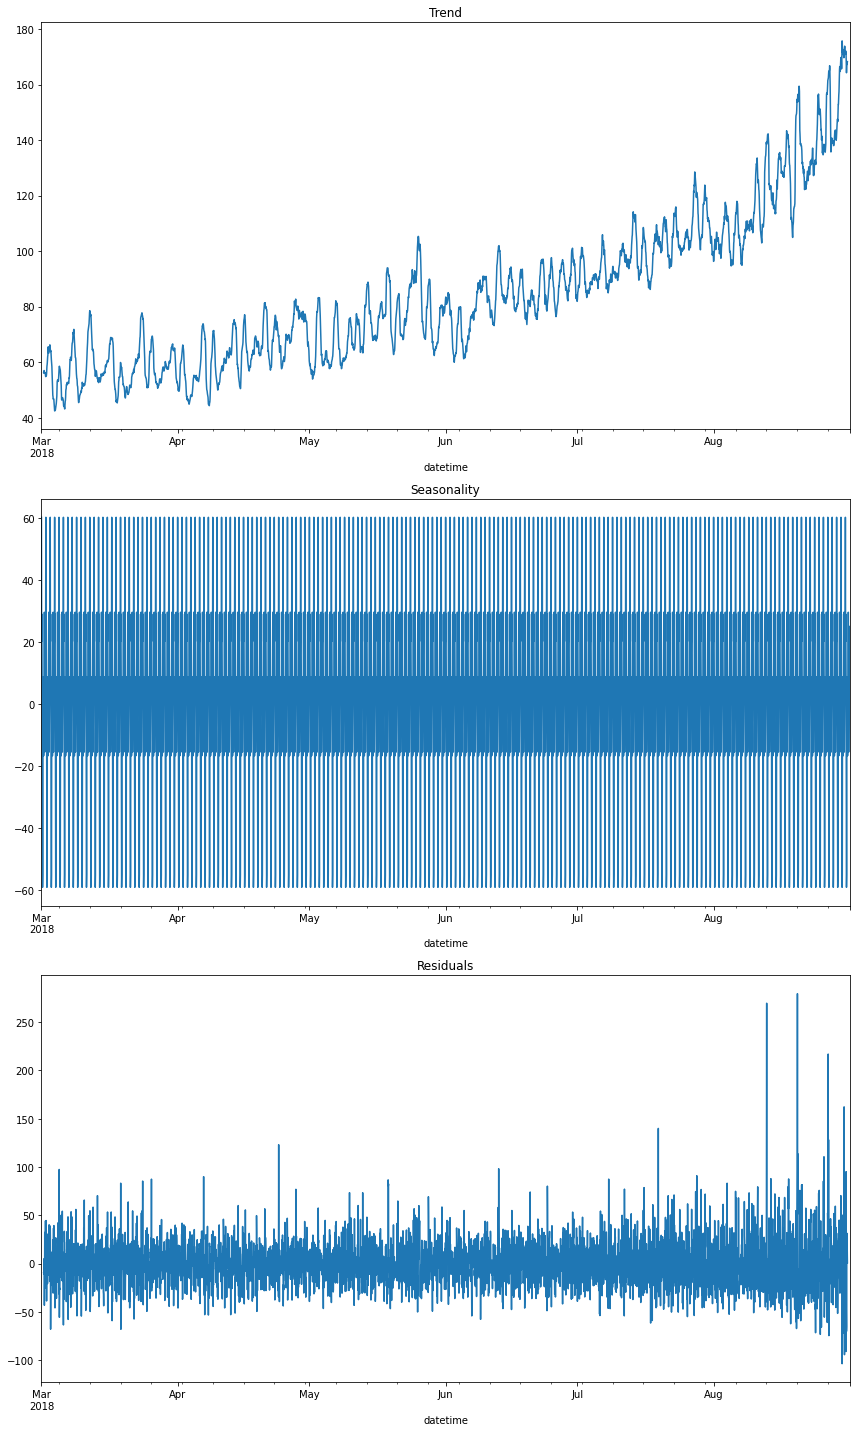

In [7]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

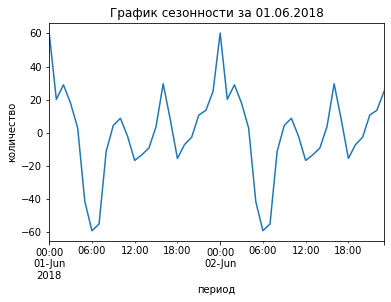

In [8]:
decomposed.seasonal['2018-06-01':'2018-06-02'].plot(ax=plt.gca());
plt.title("График сезонности за 01.06.2018");
plt.xlabel("период");
plt.ylabel("количество");

<div class="alert alert-block alert-info">  
Проверили анализ временных рядов, Графики показывают высокую частотность и суточную сезонность, уменьшим интервал и посмотрим за неделю:
</div>


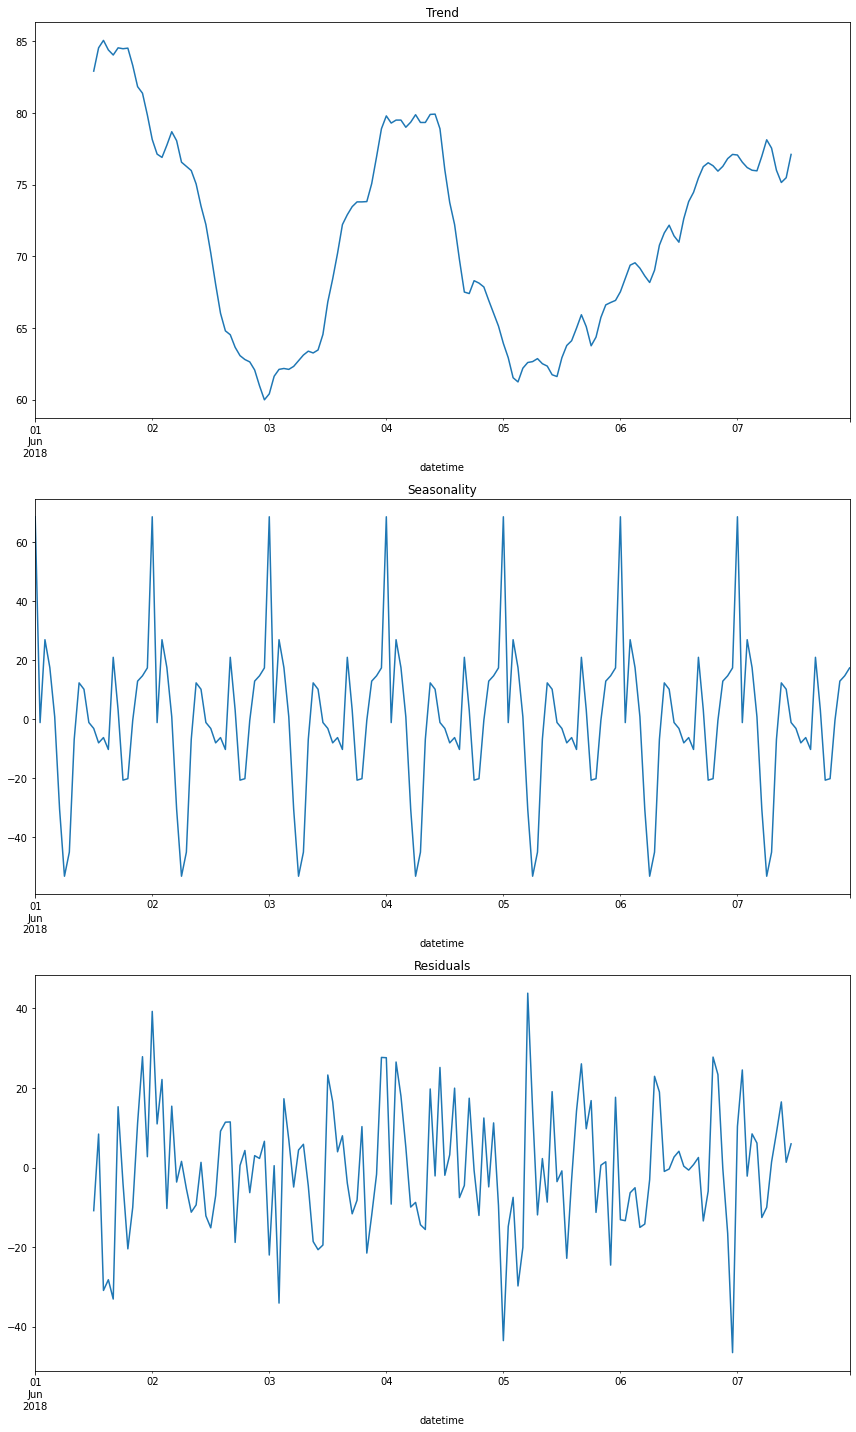

In [9]:
decomposed = seasonal_decompose(df['2018-06-01':'2018-06-07'])

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


<div class="alert alert-block alert-info">  
Теперь явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик.
</div>



<div class="alert alert-block alert-info">  
<li>За время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа, которое скорее всего вызвано ростом компании, поскольку есть гипотеза, что бизнес, связанный с такси не имеет месячной сезонности. Но данную гипотезу можно подтвердить или опровергнуть только имея данные за несколько лет.</li>
<li>На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.</li>
</div>

## Обучение

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()

In [11]:
make_features(df, 24, 100)

In [12]:
df = df.dropna()
df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,0,4,51.0,32.0,176.0,86.0,68.0,83.0,75.0,...,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,56.46
2018-03-05 05:00:00,16,0,5,34.0,51.0,32.0,176.0,86.0,68.0,83.0,...,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,55.56
2018-03-05 06:00:00,3,0,6,16.0,34.0,51.0,32.0,176.0,86.0,68.0,...,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,54.87
2018-03-05 07:00:00,14,0,7,3.0,16.0,34.0,51.0,32.0,176.0,86.0,...,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,54.19
2018-03-05 08:00:00,31,0,8,14.0,3.0,16.0,34.0,51.0,32.0,176.0,...,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,53.67


In [13]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3884, 27)
(432, 27)
(3884,)
(432,)


In [14]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
RMSE_score = make_scorer(RMSE, greater_is_better=False)


<div class="alert alert-block alert-info">  
Разбили данные на выборки, разделили их по признакам, проверили размерность, написали функцию для расчета метрики RMSE. Переходим к обучению моделей, для обучения используем 3 модели: Линейную регрессию, Случайный лес и CatBoostRegressor.
</div>



<div class="alert alert-block alert-info">  
В связи с тем, что мы работаем с временным рядом, нельзя применять кросс-валидацию в привычном виде для подбора гиперпараметров моделей с помощью GridSearchCV. Поэтому применим функцию TimeSeriesSplit().
</div>


<div class="alert alert-block alert-info">  
Линейная регрессия
</div>

In [15]:
%%time
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)

regression = make_pipeline(StandardScaler(), LinearRegression())

regression.fit(features_train, target_train)

regression_cv_score = pd.Series(cross_val_score(regression,features_train,target_train,scoring=RMSE_score,cv=my_cv)).mean()*(-1)
print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_cv_score)

Среднее качество модели линейной регрессии на кросс-валидации: 28.412402437142486
CPU times: user 185 ms, sys: 378 ms, total: 563 ms
Wall time: 537 ms



<div class="alert alert-block alert-info">  
Случайный лес
</div>

In [16]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)

forest = RandomForestRegressor()

forest_parametrs = { 'n_estimators': range(5, 30, 5),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }


forest_grid = GridSearchCV(forest, forest_parametrs, scoring=RMSE_score, cv=my_cv)
forest_grid.fit(features_train, target_train)

CPU times: user 4min 35s, sys: 454 ms, total: 4min 36s
Wall time: 4min 38s


GridSearchCV(cv=<generator object TimeSeriesSplit._split at 0x7fed14393740>,
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 15, 2),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 8, 2),
                         'n_estimators': range(5, 30, 5)},
             scoring=make_scorer(RMSE, greater_is_better=False, response_method='predict'))

In [17]:
%%time

forest_params = forest_grid.best_params_
forest_score = forest_grid.best_score_ * (-1)
print(forest_params)
print(forest_score)


{'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 25}
26.862313072021294
CPU times: user 725 µs, sys: 4 µs, total: 729 µs
Wall time: 527 µs



<div class="alert alert-block alert-info">  
CatBoost

</div>

In [18]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Объявляю модель
cb = cb.CatBoostRegressor()
#Определяю словарь с набором параметров
cb_parametrs = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10]
               }

#Применяю GridSearchCV с кросс-валидацией
cb_grid = GridSearchCV(cb, cb_parametrs, scoring=RMSE_score, cv=my_cv)
cb_grid.fit(features_train, target_train, verbose=100)

0:	learn: 28.8427470	total: 48.2ms	remaining: 48.1s
100:	learn: 17.8692599	total: 182ms	remaining: 1.62s
200:	learn: 15.9607824	total: 320ms	remaining: 1.27s
300:	learn: 14.7128169	total: 446ms	remaining: 1.04s
400:	learn: 13.5776480	total: 577ms	remaining: 861ms
500:	learn: 12.6540101	total: 704ms	remaining: 701ms
600:	learn: 11.7146676	total: 831ms	remaining: 552ms
700:	learn: 10.9266052	total: 963ms	remaining: 411ms
800:	learn: 10.2835647	total: 1.1s	remaining: 273ms
900:	learn: 9.6413875	total: 1.24s	remaining: 137ms
999:	learn: 9.0798153	total: 1.37s	remaining: 0us
0:	learn: 31.8817805	total: 2.54ms	remaining: 2.54s
100:	learn: 20.1994746	total: 167ms	remaining: 1.48s
200:	learn: 18.5270027	total: 335ms	remaining: 1.33s
300:	learn: 17.4868682	total: 502ms	remaining: 1.17s
400:	learn: 16.5724681	total: 672ms	remaining: 1s
500:	learn: 15.8557860	total: 853ms	remaining: 850ms
600:	learn: 15.2104647	total: 1.04s	remaining: 690ms
700:	learn: 14.6605748	total: 1.21s	remaining: 516ms
800

GridSearchCV(cv=<generator object TimeSeriesSplit._split at 0x7fed13970a50>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fed141b6580>,
             param_grid={'depth': [4, 6, 10], 'learning_rate': [0.03, 0.1]},
             scoring=make_scorer(RMSE, greater_is_better=False, response_method='predict'))

In [19]:
%%time

cb_params = cb_grid.best_params_
cb_score = cb_grid.best_score_ * (-1)
print(cb_params)
print(cb_score)

{'depth': 4, 'learning_rate': 0.03}
25.786364158056205
CPU times: user 595 µs, sys: 2 µs, total: 597 µs
Wall time: 500 µs


In [20]:
cb_grid.best_params_

{'depth': 4, 'learning_rate': 0.03}


<div class="alert alert-block alert-info">  
Модели обучены, гиперпараметры подобраны. Лучшая модель по итогам обучения оказалась catBoost показатель метрики 25.786364158056205 с гиперпараметрами {'depth': 4, 'learning_rate': 0.03}
    <br>
    Модель "случайный лес" показала себя чуть хужес результатом метрики 26.994042383020894 и чуть большим временнем обучения, поэтому для теста будем использовать именно случайный лес
    <br>
    linearregression имеет самый худший показатель метрики 28.412402437142486
</div>

## Тестирование

In [21]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

print('RMSE для проверки модели на адекватность:', round(RMSE(target_test, pred_previous), 3))

RMSE для проверки модели на адекватность: 59.157



<div class="alert alert-block alert-info">  
Написали функцию для построения сравнительных графиков "целевой признак - предсказание модели":

</div>

In [22]:
def graphicaizer(predictions):
    model_data = pd.DataFrame({"target":target_test, "predict":predictions})
    model_data.plot(figsize=(18, 6))
    plt.title('Cравнительный график "целевой признак - предсказание модели"')
    model_data['2018-08-22':'2018-08-24'].plot(figsize=(18, 6))
    plt.title('Cравнительный график "целевой признак - предсказание модели" за период 2018-08-22 : 2018-08-24')


<div class="alert alert-block alert-info">  
Написали функцию важности признаков
</div>

In [23]:
def feature_importance_hist(model, features_train):
    importances = list(model.feature_importances_)
    names_indices = features_train.columns
    not_null_importances = []
    not_null_indices = []

    for i in importances:
        if i>0:
            not_null_importances.append(i)
            not_null_indices.append(names_indices[importances.index(i)])
    
    plt.figure(figsize=(15, 10))
    plt.title("График важности признаков")
 
    plt.bar(range(len(not_null_importances)), not_null_importances, color="g")
    plt.xticks(range(len(importances)), not_null_indices, rotation=90)
 
    plt.tight_layout()
    plt.xlim([-1, len(not_null_importances)])
    plt.show()

In [24]:
cb_model = CatBoostRegressor(learning_rate=cb_params['learning_rate'],
                                depth=cb_params['depth'])

cb_model.fit(features_train, target_train, verbose=100)
cb_model_predictions = cb_model.predict(features_test)

#Определяю метрику RMSE
cb_RMSE = round(RMSE(target_test, cb_model_predictions), 3)
print('RMSE модели CatBoostRegressor:', cb_RMSE)

0:	learn: 38.2170015	total: 2.67ms	remaining: 2.67s
100:	learn: 24.2674485	total: 261ms	remaining: 2.32s
200:	learn: 22.7692978	total: 512ms	remaining: 2.03s
300:	learn: 21.7085475	total: 747ms	remaining: 1.73s
400:	learn: 20.7832879	total: 980ms	remaining: 1.46s
500:	learn: 19.9726626	total: 1.23s	remaining: 1.22s
600:	learn: 19.3182983	total: 1.48s	remaining: 981ms
700:	learn: 18.7501925	total: 1.71s	remaining: 728ms
800:	learn: 18.2674206	total: 1.98s	remaining: 491ms
900:	learn: 17.8233171	total: 2.19s	remaining: 241ms
999:	learn: 17.4163098	total: 2.44s	remaining: 0us
RMSE модели CatBoostRegressor: 40.665


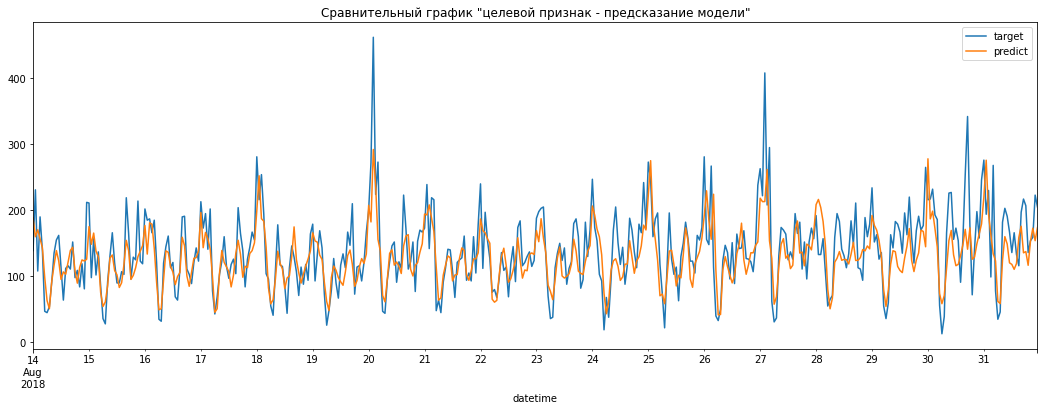

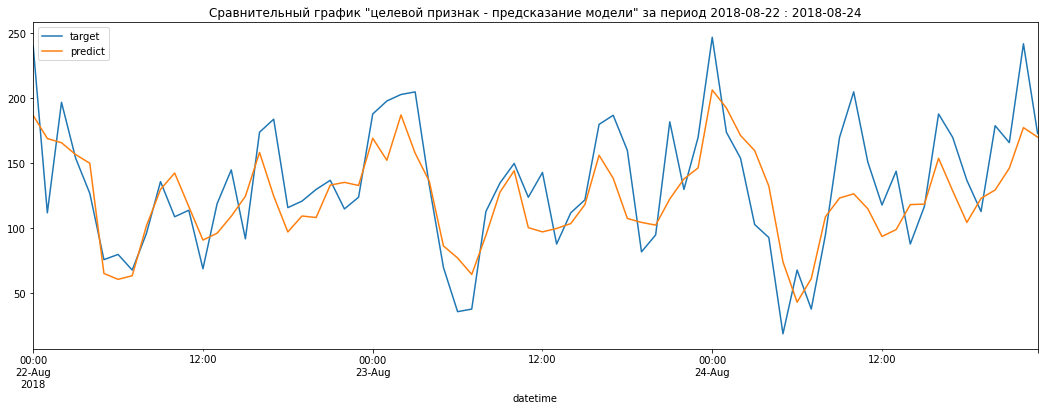

In [25]:
graphicaizer(cb_model_predictions)

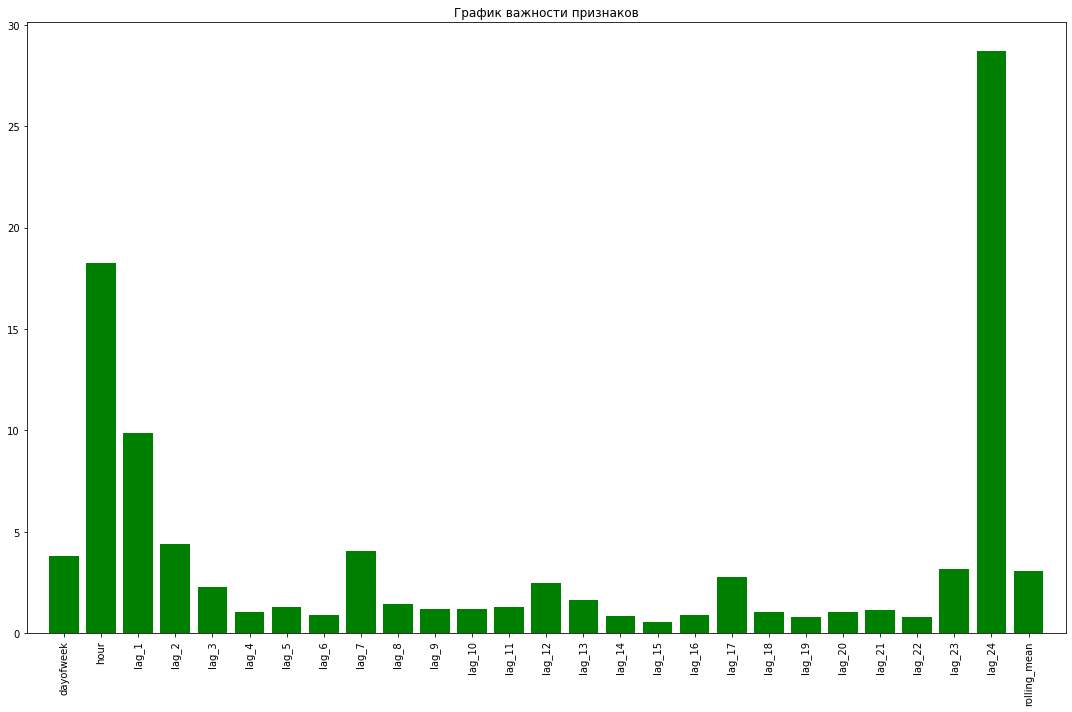

In [26]:
feature_importance_hist(cb_model, features_train)


<div class="alert alert-block alert-info">  
    <ul>ВЫВОД И ИТОГИ РАБОТЫ
        <li>1. загрузили и провели обработку данных</li>
         <li>2. Нашли суточнаю сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик. Так же наметили тренд на общее увеличение заказов такси в течение часа</li>
         <li>3. Добавили дополнительные признаки, , а именно день недели, час "отстающие значения" и скользящее среднее. Так же произвели подбор гиперпараметров</li>
         <li>4. проверли тестирование всех моделей,достигли требуемого показателя метрики RMSE. Анализ сравнительных графиков в двух масштабах, показал, что модели хуже всего справляются с предсказаниями на высоких пиках и на провалах, но в целом, угадывают направления движения. </li>
         <li>Показетель метрики rmse лучшей модели на тестовой выборке 44.109 </li>
    </ul>
</div>